In [1]:
import sys
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import pyemma
import mdtraj as md
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis

import ivac
import extq

sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [2]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [3]:
from joblib import Parallel, delayed
from multiprocess import cpu_count
n_jobs = cpu_count()

# Anton

In [3]:
u = mda.Universe("../../civsd-nowat.pdb", "../../anton2/nowat/civsd.nowat.3.dcd")

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [4]:
r217_sel = "protein and resid 217 and not backbone and type N"
phos_sel = "name O11 O12 O13 O14 and around 3.0 (protein and resid 217)"
h_sel = "protein and resid 217 and name HE HH11 HH21 HH22 HH12"
hbonds = HydrogenBondAnalysis(
    universe=u, 
    donors_sel=r217_sel, 
    hydrogens_sel=h_sel, 
    acceptors_sel=phos_sel,
    update_selections=True)

In [5]:
for a in u.select_atoms(r217_sel):
    print(a)

<Atom 1780: NE of type N of resname ARG, resid 217 and segid A and altLoc >
<Atom 1783: NH1 of type N of resname ARG, resid 217 and segid A and altLoc >
<Atom 1786: NH2 of type N of resname ARG, resid 217 and segid A and altLoc >


In [6]:
for a in u.select_atoms(phos_sel):
    print(a)

<Atom 4223: O13 of type O of resname POPC, resid 16 and segid L11 and altLoc >
<Atom 4225: O12 of type O of resname POPC, resid 16 and segid L11 and altLoc >
<Atom 16284: O14 of type O of resname POPC, resid 18 and segid L13 and altLoc >
<Atom 16285: O12 of type O of resname POPC, resid 18 and segid L13 and altLoc >


In [7]:
for a in u.select_atoms(h_sel):
    print(a)

<Atom 1781: HE of type H of resname ARG, resid 217 and segid A and altLoc >
<Atom 1784: HH11 of type H of resname ARG, resid 217 and segid A and altLoc >
<Atom 1785: HH12 of type H of resname ARG, resid 217 and segid A and altLoc >
<Atom 1787: HH21 of type H of resname ARG, resid 217 and segid A and altLoc >
<Atom 1788: HH22 of type H of resname ARG, resid 217 and segid A and altLoc >


## Parallel calculations

In [8]:
def hbond_anton(trajfile, r_i):
    u = mda.Universe("../../civsd-nowat.pdb", trajfile)
    r_sel = f"protein and resid {r_i} and not backbone and type N"
    phos_sel = f"name O11 O12 O13 O14 and around 3.0 (protein and resid {r_i})"
    h_sel = f"protein and resid {r_i} and name HE HH11 HH21 HH22 HH12"
    hbonds = HydrogenBondAnalysis(
        universe=u, 
        donors_sel=r_sel, 
        hydrogens_sel=h_sel, 
        acceptors_sel=phos_sel,
        update_selections=True)
    return hbonds
        
def run_analysis(analysis):
    analysis.run()
    return analysis.count_by_time()

In [11]:
dcds = []
for i in range(3, 119):
    if i == 82:
        continue
    dcds.append(f"/project/dinner/scguo/ci-vsd/anton2/nowat/civsd.nowat.{i}.dcd")
print(len(dcds))

115


In [12]:
analysis_ensemble_217 = [hbond_anton(file, 217) for file in dcds]

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/topology/PDBParser.py:317: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


In [13]:
results_217 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_217)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [14]:
analysis_ensemble_223 = [hbond_anton(file, 223) for file in dcds]

In [15]:
results_223 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_223)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done   3 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done   4 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done   5 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done   6 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done   7 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done   8 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done   9 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done  11 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done  12 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done  13 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=48)]: Done  15 tasks      | elapsed:  

In [17]:
analysis_ensemble_226 = [hbond_anton(file, 226) for file in dcds]

In [18]:
results_226 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_226)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [19]:
analysis_ensemble_229 = [hbond_anton(file, 229) for file in dcds]

In [20]:
results_229 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_229)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [21]:
analysis_ensemble_232 = [hbond_anton(file, 232) for file in dcds]

In [22]:
results_232 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_232)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [28]:
hb_phos = np.stack((results_217, results_223, results_226, results_229, results_232), axis=-1)

In [29]:
hb_phos.shape

(115, 10001, 5)

In [30]:
np.save("../../data/raw_feat/hbond_phos_anton2.npy", hb_phos)

# analyze

In [4]:
hb_phos = np.load("../../data/raw_feat/hbond_phos_anton2.npy")
print(hb_phos.shape)

(115, 10001, 5)


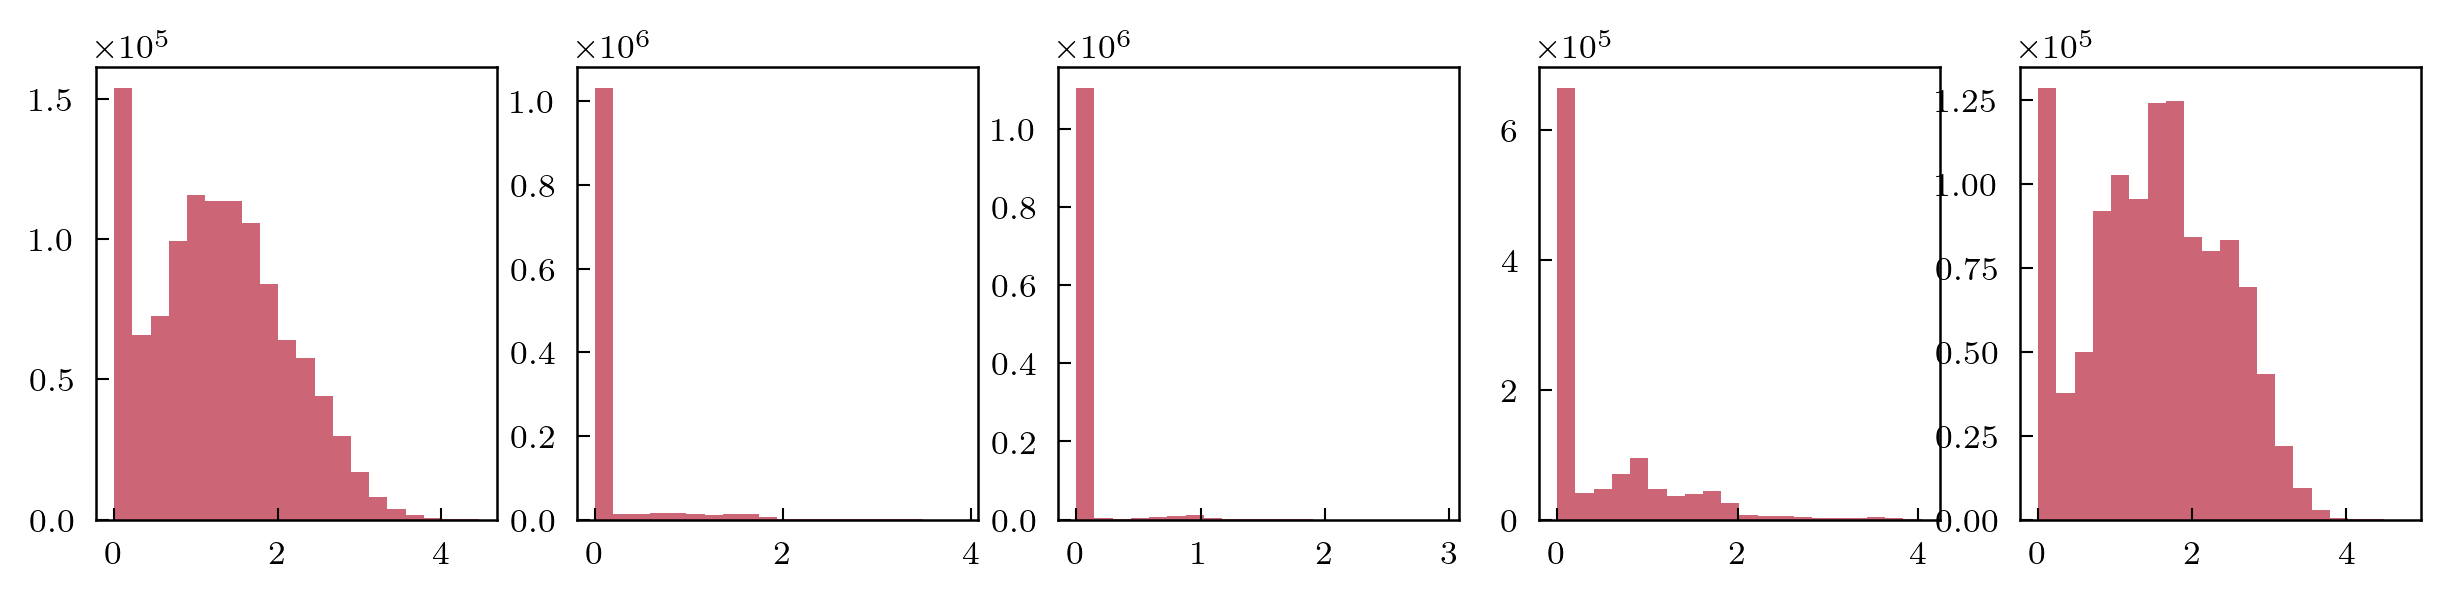

In [9]:
f, axs = plt.subplots(1, 5, figsize=(10, 2), dpi=300)
for i, ax in enumerate(axs):
    smoothed = util.smooth_moving_average(list(hb_phos[..., i]), 10)
    ax.hist(np.concatenate(smoothed), bins=20)

In [10]:
# load committors and weights
import h5py

In [13]:
f = h5py.File("../../data/feat2_dist_du_anton2/feat2_dist_anton2.h5", mode="r")
q = f["y"][3_000_000:]
weights = f["weights"][3_000_000:]

In [16]:
q = np.split(q, 115)
weights = np.split(weights, 115)

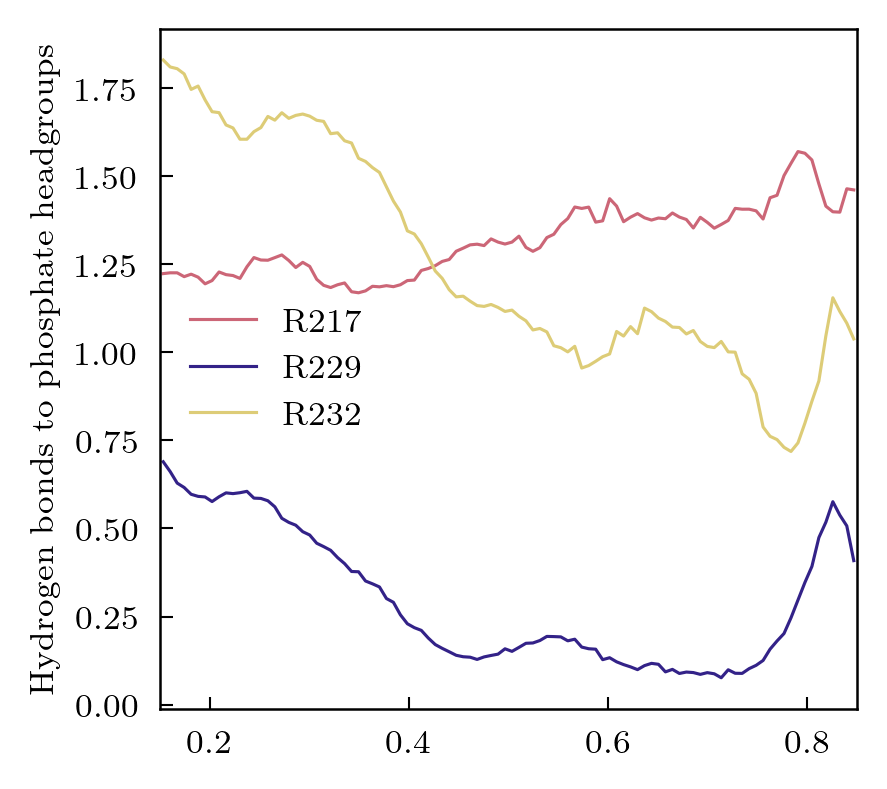

In [19]:
f, ax = plt.subplots(dpi=300)
lo, hi = 0.15, 0.85
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

for i in (0, 3, 4):
    q_dens = extq.projection.average1d(q, hb_phos[..., i], weights, qe)
    ax.plot(qc, q_dens)
plt.xlim([lo, hi])
plt.ylabel("Hydrogen bonds to phosphate headgroups")
plt.legend(["R217", "R229", "R232"])

# Old Anton

In [4]:
u = mda.Universe("../../models/MD-clustering-center/civsd.psf", "/project/dinner/scguo/anton-old/civsd_0.dcd")

In [5]:
r217_sel = "protein and resid 217 and not backbone and type NC2"
phos_sel = "name O11 O12 O13 O14 and around 3.0 (protein and resid 217)"
h_sel = "protein and resid 217 and type HC"
hbonds = HydrogenBondAnalysis(
    universe=u, 
    donors_sel=r217_sel, 
    hydrogens_sel=h_sel, 
    acceptors_sel=phos_sel,
    update_selections=True)

In [25]:
for a in u.select_atoms(r217_sel):
    print(a)

<Atom 1780: NE of type NC2 of resname ARG, resid 217 and segid A>
<Atom 1783: NH1 of type NC2 of resname ARG, resid 217 and segid A>
<Atom 1786: NH2 of type NC2 of resname ARG, resid 217 and segid A>


In [26]:
for a in u.select_atoms(phos_sel):
    print(a)

<Atom 20329: O14 of type O2L of resname POPC, resid 11 and segid L13>
<Atom 20331: O11 of type OSLP of resname POPC, resid 11 and segid L13>


In [27]:
for a in u.select_atoms(h_sel):
    print(a)

<Atom 1781: HE of type HC of resname ARG, resid 217 and segid A>
<Atom 1784: HH11 of type HC of resname ARG, resid 217 and segid A>
<Atom 1785: HH12 of type HC of resname ARG, resid 217 and segid A>
<Atom 1787: HH21 of type HC of resname ARG, resid 217 and segid A>
<Atom 1788: HH22 of type HC of resname ARG, resid 217 and segid A>


## Parallel calculations

In [6]:
def hbond_anton(trajfile, r_i):
    u = mda.Universe("../../models/MD-clustering-center/civsd.psf", trajfile)
    r_sel = f"protein and resid {r_i} and not backbone and type NC2"
    phos_sel = f"name O11 O12 O13 O14 and around 3.0 (protein and resid {r_i})"
    h_sel = f"protein and resid {r_i} and type HC"
    hbonds = HydrogenBondAnalysis(
        universe=u, 
        donors_sel=r_sel, 
        hydrogens_sel=h_sel, 
        acceptors_sel=phos_sel,
        update_selections=True)
    return hbonds
        
def run_analysis(analysis):
    analysis.run()
    return analysis.count_by_time()

In [29]:
dcds = []
for i in range(179):
    dcds.append(f"/project/dinner/scguo/anton-old/civsd_{i}.dcd")
print(len(dcds))

179


In [30]:
analysis_ensemble_217 = [hbond_anton(file, 217) for file in dcds]

In [41]:
results_217 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_217)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [32]:
analysis_ensemble_223 = [hbond_anton(file, 223) for file in dcds]

In [42]:
results_223 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_223)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=48)]: Done   3 tasks      | elapsed:  2.2min
[Parallel(n_jobs=48)]: Done   4 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   6 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   7 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   8 tasks      | elapsed:  2.4min
[Parallel(n_jobs=48)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=48)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=48)]: Done  11 tasks      | elapsed:  2.5min
[Parallel(n_jobs=48)]: Done  12 tasks      | elapsed:  2.5min
[Parallel(n_jobs=48)]: Done  13 tasks      | elapsed:  2.6min
[Parallel(n_jobs=48)]: Done  14 tasks      | elapsed:  2.7min
[Parallel(n_jobs=48)]: Done  15 tasks      | elapsed:  

In [34]:
analysis_ensemble_226 = [hbond_anton(file, 226) for file in dcds]

In [35]:
results_226 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_226)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=48)]: Done   3 tasks      | elapsed:  2.2min
[Parallel(n_jobs=48)]: Done   4 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   6 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   7 tasks      | elapsed:  2.5min
[Parallel(n_jobs=48)]: Done   8 tasks      | elapsed:  2.5min
[Parallel(n_jobs=48)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=48)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=48)]: Done  11 tasks      | elapsed:  2.6min
[Parallel(n_jobs=48)]: Done  12 tasks      | elapsed:  2.6min
[Parallel(n_jobs=48)]: Done  13 tasks      | elapsed:  2.7min
[Parallel(n_jobs=48)]: Done  14 tasks      | elapsed:  2.7min
[Parallel(n_jobs=48)]: Done  15 tasks      | elapsed:  

In [36]:
analysis_ensemble_229 = [hbond_anton(file, 229) for file in dcds]

In [37]:
results_229 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_229)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Vers

In [38]:
analysis_ensemble_232 = [hbond_anton(file, 232) for file in dcds]

In [39]:
results_232 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_232)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [ ]:
results_217 = [t[:10000] for t in results_217]
results_223 = [t[:10000] for t in results_223]
results_226 = [t[:10000] for t in results_226]
results_229 = [t[:10000] for t in results_229]
results_232 = [t[:10000] for t in results_232]
hb_phos = np.stack((results_217, results_223, results_226, results_229, results_232), axis=-1)

In [ ]:
for t in results_217:
    print(len(t))

In [ ]:
results_217[0].shape

(10000,)

In [ ]:
hb_phos.shape

In [53]:
np.save("../../data/raw_feat/hbond_phos_0-178.npy", hb_phos)

## 179-300

In [29]:
dcds = []
for i in range(179):
    dcds.append(f"/project/dinner/scguo/anton-old/civsd_{i}.dcd")
print(len(dcds))

179


In [30]:
analysis_ensemble_217 = [hbond_anton(file, 217) for file in dcds]

In [41]:
results_217 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_217)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [32]:
analysis_ensemble_223 = [hbond_anton(file, 223) for file in dcds]

In [42]:
results_223 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_223)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=48)]: Done   3 tasks      | elapsed:  2.2min
[Parallel(n_jobs=48)]: Done   4 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   6 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   7 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   8 tasks      | elapsed:  2.4min
[Parallel(n_jobs=48)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=48)]: Done  10 tasks      | elapsed:  2.5min
[Parallel(n_jobs=48)]: Done  11 tasks      | elapsed:  2.5min
[Parallel(n_jobs=48)]: Done  12 tasks      | elapsed:  2.5min
[Parallel(n_jobs=48)]: Done  13 tasks      | elapsed:  2.6min
[Parallel(n_jobs=48)]: Done  14 tasks      | elapsed:  2.7min
[Parallel(n_jobs=48)]: Done  15 tasks      | elapsed:  

In [34]:
analysis_ensemble_226 = [hbond_anton(file, 226) for file in dcds]

In [35]:
results_226 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_226)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=48)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=48)]: Done   3 tasks      | elapsed:  2.2min
[Parallel(n_jobs=48)]: Done   4 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   5 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   6 tasks      | elapsed:  2.3min
[Parallel(n_jobs=48)]: Done   7 tasks      | elapsed:  2.5min
[Parallel(n_jobs=48)]: Done   8 tasks      | elapsed:  2.5min
[Parallel(n_jobs=48)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=48)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=48)]: Done  11 tasks      | elapsed:  2.6min
[Parallel(n_jobs=48)]: Done  12 tasks      | elapsed:  2.6min
[Parallel(n_jobs=48)]: Done  13 tasks      | elapsed:  2.7min
[Parallel(n_jobs=48)]: Done  14 tasks      | elapsed:  2.7min
[Parallel(n_jobs=48)]: Done  15 tasks      | elapsed:  

In [36]:
analysis_ensemble_229 = [hbond_anton(file, 229) for file in dcds]

In [37]:
results_229 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_229)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Vers

In [38]:
analysis_ensemble_232 = [hbond_anton(file, 232) for file in dcds]

In [39]:
results_232 = Parallel(n_jobs=n_jobs, verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_232)

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [7]:

remove = {1282,
    1283,
    1284,
    1285,
    1286,
    1288,
    1289,
    1290,
    1187,
    1188,
    1189,
    1190,
    1191,
    1197,
    1198,
    1199,
    1203,
    1205,
    1206,
    1207,
    1211,
    1212,
    1213,
    1214,
    1215,
    1225,
    1226,
    1227,
    1228,
    1231,
    1232,
    1233,
    1236,
    1237,
    1238,
    1242,
    1245,
    1246,
    1252,
    1253,
    1260,
    1261,
    1262,
    1263,
    1266,
    1267,
    1268,
    1269,
    1270,
    1271,
    1272,
    1273,
    1274,
    1275,
    1276,
    1277,
    1278,
    1279,
}
files = []
for i in range(179, 295):
    if i == 180:
        continue
    if (i + 1000) not in remove:
        files.append(f"/project/dinner/scguo/anton-old/civsd_{i}.dcd")

In [8]:
files

['/project/dinner/scguo/anton-old/civsd_179.dcd',
 '/project/dinner/scguo/anton-old/civsd_181.dcd',
 '/project/dinner/scguo/anton-old/civsd_182.dcd',
 '/project/dinner/scguo/anton-old/civsd_183.dcd',
 '/project/dinner/scguo/anton-old/civsd_184.dcd',
 '/project/dinner/scguo/anton-old/civsd_185.dcd',
 '/project/dinner/scguo/anton-old/civsd_186.dcd',
 '/project/dinner/scguo/anton-old/civsd_192.dcd',
 '/project/dinner/scguo/anton-old/civsd_193.dcd',
 '/project/dinner/scguo/anton-old/civsd_194.dcd',
 '/project/dinner/scguo/anton-old/civsd_195.dcd',
 '/project/dinner/scguo/anton-old/civsd_196.dcd',
 '/project/dinner/scguo/anton-old/civsd_200.dcd',
 '/project/dinner/scguo/anton-old/civsd_201.dcd',
 '/project/dinner/scguo/anton-old/civsd_202.dcd',
 '/project/dinner/scguo/anton-old/civsd_204.dcd',
 '/project/dinner/scguo/anton-old/civsd_208.dcd',
 '/project/dinner/scguo/anton-old/civsd_209.dcd',
 '/project/dinner/scguo/anton-old/civsd_210.dcd',
 '/project/dinner/scguo/anton-old/civsd_216.dcd',


In [10]:
analysis_ensemble_217 = [hbond_anton(file, 217) for file in files]

In [11]:
results_217 = Parallel(n_jobs=(n_jobs // 2), verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_217)

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [12]:
analysis_ensemble_223 = [hbond_anton(file, 223) for file in files]

In [13]:
results_223 = Parallel(n_jobs=(n_jobs //2), verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_223)

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [14]:
analysis_ensemble_226 = [hbond_anton(file, 226) for file in files]

In [ ]:
results_226 = Parallel(n_jobs=(n_jobs // 2), verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_226)

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [16]:
analysis_ensemble_229 = [hbond_anton(file, 229) for file in files]

In [17]:
results_229 = Parallel(n_jobs=(n_jobs // 2), verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_229)

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [18]:
analysis_ensemble_232 = [hbond_anton(file, 232) for file in files]

In [ ]:
results_232 = Parallel(n_jobs=(n_jobs // 2), verbose=20)(
    delayed(run_analysis)(analysis) for analysis in analysis_ensemble_232)

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. 

In [57]:
results_217[0].shape

(100000,)

In [58]:
hb_new = [np.stack((r217, r223, r226, r229, r232), axis=-1) for (r217, r223, r226, r229, r232) in zip(
    results_217, results_223, results_226, results_229, results_232)]

In [65]:
hb_new_short = []
for hb in hb_new:
    length = len(hb)
    if length > 10000 and length < 100000:
        length = 10000
    hb_new_short.append(hb[:length])

In [66]:
for t in hb_new_short:
    print(len(t))

100000
100000
100000
100000
100000
100000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


In [67]:
results_217[0].shape

(100000,)

In [68]:
hb_new[0].shape

(100000, 5)

In [77]:
np.save("../../data/raw_feat/hbond_phos_179-end.npy", hb_new_short)

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Plot

In [28]:
# load committors and weights
import h5py

In [29]:
f = h5py.File("../../data/feat2_dist_du_anton2/feat2_dist_anton2.h5", mode="r")
q = f["y"]
weights = f["weights"]

In [41]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy"))
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy"))
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# Hydrogen bonding

hb_sb = list(np.load(f"{DATA_DIR}/raw_feat/hbonds.npy", allow_pickle=True))
hb_sb.extend(np.load(f"{DATA_DIR}/raw_feat/hbonds_anton2.npy"))

In [31]:
traj_inds = util.split_indices(cv_trajs)
q = np.split(q, traj_inds)
weights = np.split(weights, traj_inds)

In [32]:
q_no180 = [*q[:180], *q[181:]]
w_no180 = [*weights[:180], *weights[181:]]

In [43]:
len(q_no180)

351

In [78]:
hb_phos = list(np.load(f"{DATA_DIR}/raw_feat/hbond_phos_0-178.npy", allow_pickle=True))
print(len(hb_phos), hb_phos[0].shape)
hb_phos.extend(np.load(f"{DATA_DIR}/raw_feat/hbond_phos_179-end.npy", allow_pickle=True))
print(len(hb_phos))
hb_phos.extend(np.load(f"{DATA_DIR}/raw_feat/hbond_phos_anton2.npy"))
print(len(hb_phos))

179 (10000, 5)
236
351


In [80]:
for h, t, w in zip(hb_phos, q_no180, w_no180):
    print(h.shape, t.shape, w.shape)

(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10000,) (10000,)
(10000, 5) (10

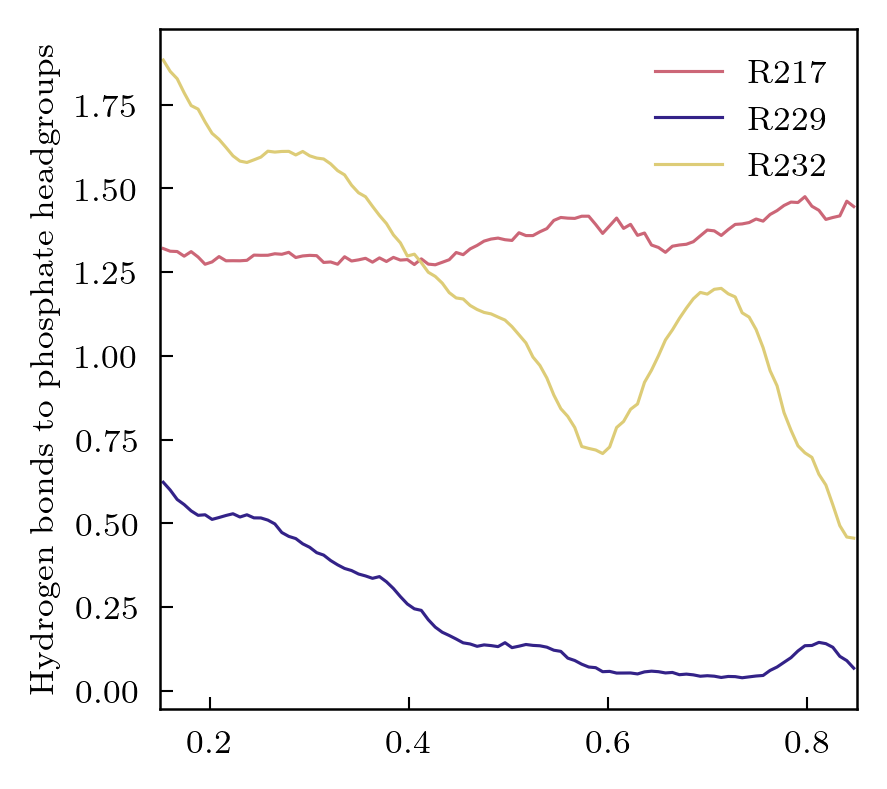

In [81]:
f, ax = plt.subplots(dpi=300)
lo, hi = 0.15, 0.85
qe = np.linspace(lo, hi, 101)
qc = (qe[1:] + qe[:-1]) / 2

for i in (0, 3, 4):
    hb_traj = [t[:, i] for t in hb_phos]
    q_dens = extq.projection.average1d(q_no180, hb_traj, w_no180, qe)
    ax.plot(qc, q_dens)
plt.xlim([lo, hi])
plt.ylabel("Hydrogen bonds to phosphate headgroups")
plt.legend(["R217", "R229", "R232"])